In [1]:
import pandas as pd
import numpy as np
import chardet
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

In [2]:
df = pd.read_csv("ecom_yl.csv", sep=",", decimal='.')

In [3]:
#приводим названия столбцов в формат PEP8

df.columns = df.columns.str.lower().str.replace(' ', '_')

In [4]:
# функция для определения времени суток

def time(row):
    times = {
        'morning': [datetime.time(hour=6), datetime.time(hour=9, minute=59)],
        'day': [datetime.time(hour=10), datetime.time(hour=16, minute=59)],
        'evening': [datetime.time(hour=17), datetime.time(hour=21, minute=59)],
        'night': [datetime.time(hour=22), datetime.time(hour=5, minute=59)]
    }
    d = datetime.date(2021, 10, 12)
    a = row.session_start.time()
    b = row.session_end.time()
    for i in times.keys():
        if a >= times[i][0] and b <= times[i][1]:
            return i
        if times[i][0] <= a < times[i][1] and b > times[i][1]:
            if row.sessiondurationsec / 2 <= (
                datetime.datetime.combine(d, times[i][1]) - datetime.datetime.combine(
                    d, a)).seconds:
                return i
        if a <= times[i][0] and b >= times[i][1]:
            return i
        if a < times[i][0] and times[i][0] < b <= times[i][1]:
            if row.sessiondurationsec / 2 <= (
                datetime.datetime.combine(d, b) - datetime.datetime.combine(
                    d, times[i][0])).seconds:
                return i
        if i == 'night' and (a <= times[i][1] and b <= times[i][1] or
                             a >= times[i][0] and b >= times[i][0]):
            return i

In [5]:
#исправляем неправильные названия в region

dict_regions = {'United States':'United States', 'Frаnce':'France', 'Unjted States' : 'United States', 'Germany' : 'Germany', 
               'UK' : 'UK', 'France':'France', 'Frаncе': 'France', 'germany':'Germany', 'UК':'UK'}
df["region"] = df["region"].map(dict_regions)

In [6]:
#исправляем неправильные названия в channel

dict_channels = {'социальные сети' : 'социальные сети', 'organic':'organic', 'реклама у блогеров':'реклама у блогеров', 
                 'контексная реклама' : 'контекстная реклама', 'контекстная реклама':'контекстная реклама', 'email-рассылки':'email-рассылки'}
df["channel"] = df["channel"].map(dict_channels)

In [7]:
#исправляем неправильные названия в device

dict_devices = {'iPhone' : 'iPhone', 'PC' : 'PC', 'Mac' : 'Mac', 'Android' : 'Android', 'android' : 'Android'}
df["device"] = df["device"].map(dict_devices)

In [8]:
#убираем выбросы у SessionDuration с помощью 3-ного интерквартильного размаха

def transformed(x):
    i_quant = x.quantile(0.75) - x.quantile(0.25)
    k = x > (x.quantile(0.75) + i_quant * 3)
    x[k] = x.median()
    return x
    
df["sessiondurationsec"] = df.groupby("channel", group_keys=False)["sessiondurationsec"].transform(transformed)
df['revenue'] = df['revenue'].apply(lambda x: 4999 if (x == 100000) or (x == 1) else x)

In [9]:
#переводим даты из строкого формата в datetime

df['session_start'] = pd.to_datetime(df['session_start'])
df['session_end'] = pd.to_datetime(df['session_end'])

In [10]:
#заполняем пропуски в SessionDurationSec

df['sessiondurationsec'] = (df['session_end'] - df['session_start']).dt.total_seconds()

In [11]:
#Удаляем сессии длящиеся 5 секунд и меньше, в которых не было покупок

df = df[(df["sessiondurationsec"] > 5) | ((df["sessiondurationsec"] <= 5) & (df['revenue'].notna()))]

In [12]:
# число явных дубликатов и их удаление

i_see_it = len(df) - len(df.drop_duplicates())
#print(i_see_it) -> 3
df = df.drop_duplicates()

In [13]:
# заполнение пропусков
df['region'] = df.groupby('month')['region'].transform(lambda x: x.fillna(x.mode()[0]))
df['device'] = df.groupby('month')['device'].transform(lambda x: x.fillna(x.mode()[0]))
df['channel'] = df.groupby('month')['channel'].transform(lambda x: x.fillna(x.mode()[0]))

In [14]:
dup_id = [434852403169, 213468351687, 679176482300, 87458247642, 588840798518, 61219447121, 427486793654, 632186207840, 375373200590, 634503344070, 825998445466]
for id in dup_id:
    df.loc[(df['user_id'] == id,'region')] = df[df['user_id'] == id]['region'].mode()[0]
    df.loc[(df['user_id'] == id,'device')] = df[df['user_id'] == id]['device'].mode()[0]
    df.loc[(df['user_id'] == id,'channel')] = df[df['user_id'] == id]['channel'].mode()[0]

In [15]:
#очищение неправильных данных в promo_code

df['promo_code'] = df['promo_code'].map(lambda x: 1 if not pd.isna(x) and x else x)

In [16]:
#Добавление итоговой суммы покупки с учетом использования промокода

df['revenue_with_promo_code'] = df.apply(lambda x: 0.9 * x.revenue if x.promo_code == 1 and not pd.isna(x.revenue) else x.revenue, axis=1)

In [17]:
#Обозначение платящих пользователей

df['payer'] = df['revenue'].apply(lambda x: 1 if not pd.isna(x) else 0)

In [18]:
df['time_of_day'] = df.apply(time, axis=1)

In [19]:
df.to_csv("res.csv", index=False)

In [20]:
df = pd.read_csv("res.csv", sep=",", decimal='.')

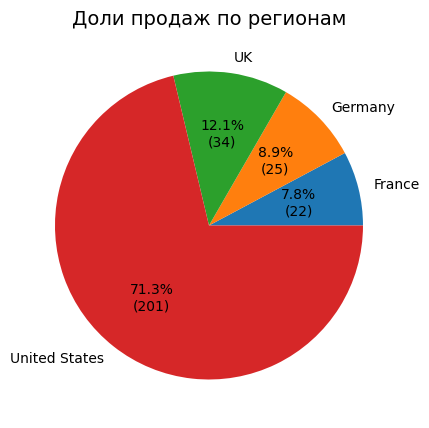

In [21]:
#Диаграмма долей продаж по регионам

def my_fmt(x):
    return '{:.1f}%\n({:.0f})'.format(x, df['payer'].sum() * x / 100)

value_counts = df.groupby(['region'])['payer'].sum()
ax = value_counts.plot.pie(autopct=my_fmt, labels = value_counts.index,
                          figsize=(15, 5), fontsize=10)
ax.set_ylabel("")
plt.title(label="Доли продаж по регионам", fontsize=14)
plt.show()

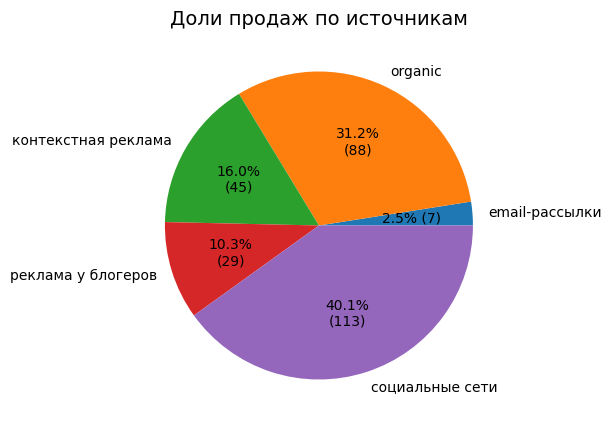

In [22]:
#Диаграмма долей продаж по источникам

def my_fmt(x):
    if (round(df['payer'].sum() * x / 100) == 7):
        return '{:.1f}% ({:.0f})'.format(x, df['payer'].sum() * x / 100)
    return '{:.1f}%\n({:.0f})'.format(x, df['payer'].sum() * x / 100)

value_counts = df.groupby(['channel'])['payer'].sum()
ax = value_counts.plot.pie(autopct=my_fmt, labels = value_counts.index,
                          figsize=(15, 5), fontsize=10)
ax.set_ylabel("")
plt.title(label="Доли продаж по источникам", fontsize=14)
plt.show()

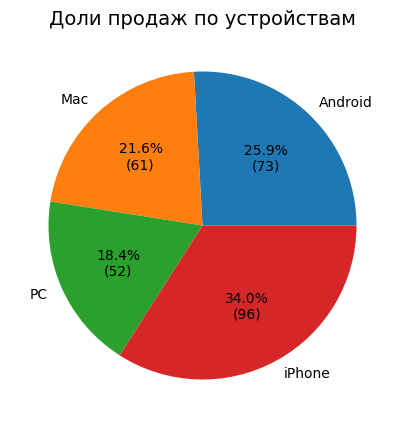

In [23]:
#Диаграмма долей продаж по устройствам

def my_fmt(x):
    return '{:.1f}%\n({:.0f})'.format(x, df['payer'].sum() * x / 100)

value_counts = df.groupby(['device'])['payer'].sum()
ax = value_counts.plot.pie(autopct=my_fmt, labels = value_counts.index,
                          figsize=(15, 5), fontsize=10)
ax.set_ylabel("")
plt.title(label="Доли продаж по устройствам", fontsize=14)
plt.show()

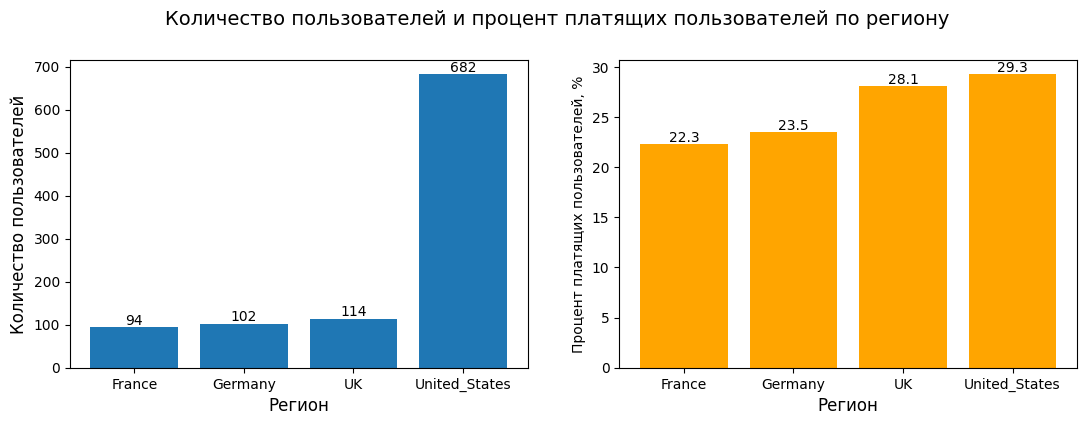

In [24]:
#Количество пользователей с разбивкой на платящих/не платящих по региону

france_users_count = len(df[df['region'] == 'France']['user_id'].unique())
germany_users_count = len(df[df['region'] == 'Germany']['user_id'].unique())
UK_users_count = len(df[df['region'] == 'UK']['user_id'].unique())
united_states_users_count = len(df[df['region'] == 'United States']['user_id'].unique())
fig, axs = plt.subplots(1, 2, figsize=(13, 4))
france_paying_users_count = round(len(df[(df['region'] == 'France') & (df['payer'] == 1)]['user_id'].unique()) / france_users_count * 100, 1)
germany_paying_users_count = round(len(df[(df['region'] == 'Germany') & (df['payer'] == 1)]['user_id'].unique()) / germany_users_count * 100, 1)
UK_paying_users_count = round(len(df[(df['region'] == 'UK') & (df['payer'] == 1)]['user_id'].unique()) / UK_users_count * 100, 1)
united_states_paying_users_count = round(len(df[(df['region'] == 'United States') & (df['payer'] == 1)]['user_id'].unique()) / united_states_users_count * 100,1)
axs[0].bar(['France', 'Germany', 'UK', 'United_States'], [france_users_count, germany_users_count, UK_users_count, united_states_users_count])
axs[0].set_xlabel("Регион", fontsize=12)
axs[0].set_ylabel("Количество пользователей", fontsize=12)
axs[0].bar_label (axs[0].containers [ 0 ])
axs[1].bar(['France', 'Germany', 'UK', 'United_States'], [france_paying_users_count, germany_paying_users_count, UK_paying_users_count, united_states_paying_users_count], color='orange')
axs[1].set_xlabel("Регион", fontsize=12)
axs[1].set_ylabel("Процент платящих пользователей, %", fontsize=10)
axs[1].bar_label (axs[1].containers[0])
plt.suptitle("Количество пользователей и процент платящих пользователей по региону", fontsize=14, y=1.005)
plt.show()

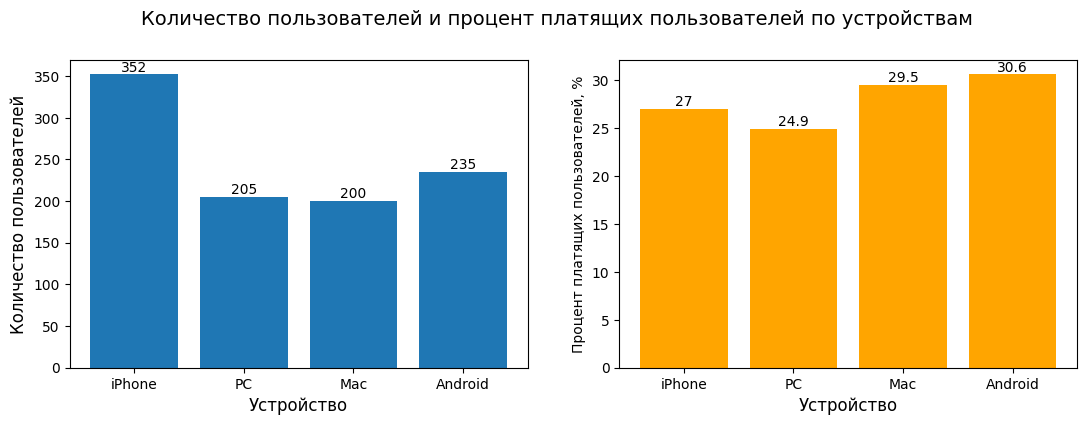

In [25]:
#Количество пользователей с разбивкой на платящих/не платящих по устройствам

iPhone_users_count = len(df[df['device'] == 'iPhone']['user_id'].unique())
PC_users_count = len(df[df['device'] == 'PC']['user_id'].unique())
Mac_users_count = len(df[df['device'] == 'Mac']['user_id'].unique())
Android_users_count = len(df[df['device'] == 'Android']['user_id'].unique())
fig, axs = plt.subplots(1, 2, figsize=(13, 4))
iPhone_paying_users_count = round(len(df[(df['device'] == 'iPhone') & (df['payer'] == 1)]['user_id'].unique()) / iPhone_users_count * 100, 1)
PC_paying_users_count = round(len(df[(df['device'] == 'PC') & (df['payer'] == 1)]['user_id'].unique()) / PC_users_count * 100, 1)
Mac_paying_users_count = round(len(df[(df['device'] == 'Mac') & (df['payer'] == 1)]['user_id'].unique()) / Mac_users_count * 100, 1)
Android_paying_users_count = round(len(df[(df['device'] == 'Android') & (df['payer'] == 1)]['user_id'].unique()) / Android_users_count * 100,1)
axs[0].bar(['iPhone', 'PC', 'Mac', 'Android'], [iPhone_users_count, PC_users_count, Mac_users_count, Android_users_count])
axs[0].set_xlabel("Устройство", fontsize=12)
axs[0].set_ylabel("Количество пользователей", fontsize=12)
axs[0].bar_label (axs[0].containers [ 0 ])
axs[1].bar(['iPhone', 'PC', 'Mac', 'Android'], [iPhone_paying_users_count, PC_paying_users_count, Mac_paying_users_count, Android_paying_users_count], color='orange')
axs[1].set_xlabel("Устройство", fontsize=12)
axs[1].set_ylabel("Процент платящих пользователей, %", fontsize=10)
axs[1].bar_label (axs[1].containers[0])
plt.suptitle("Количество пользователей и процент платящих пользователей по устройствам", fontsize=14, y=1.005)
plt.show()

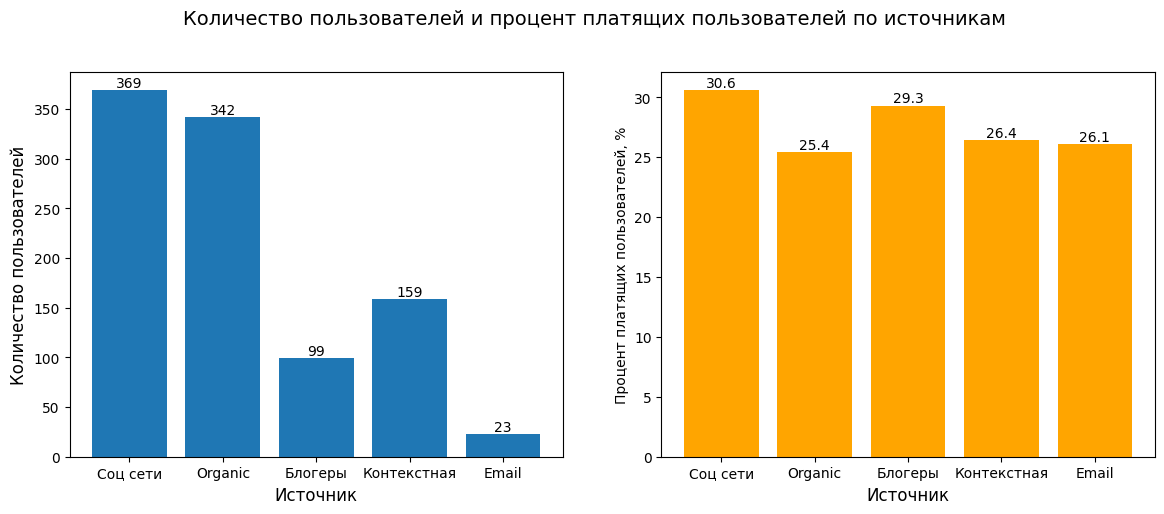

In [26]:
#Количество пользователей с разбивкой на платящих/не платящих по источникам

social_netw_users_count = len(df[df['channel'] == 'социальные сети']['user_id'].unique())
organic_users_count = len(df[df['channel'] == 'organic']['user_id'].unique())
blogers_users_count = len(df[df['channel'] == 'реклама у блогеров']['user_id'].unique())
context_users_count = len(df[df['channel'] == 'контекстная реклама']['user_id'].unique())
email_users_count = len(df[df['channel'] == 'email-рассылки']['user_id'].unique())
fig, axs = plt.subplots(1, 2, figsize=(14, 5))
social_netw_paying_users_count = round(len(df[(df['channel'] == 'социальные сети') & (df['payer'] == 1)]['user_id'].unique()) / social_netw_users_count * 100, 1)
organic_paying_users_count = round(len(df[(df['channel'] == 'organic') & (df['payer'] == 1)]['user_id'].unique()) / organic_users_count * 100, 1)
blogers_paying_users_count = round(len(df[(df['channel'] == 'реклама у блогеров') & (df['payer'] == 1)]['user_id'].unique()) / blogers_users_count * 100, 1)
context_paying_users_count = round(len(df[(df['channel'] == 'контекстная реклама') & (df['payer'] == 1)]['user_id'].unique()) / context_users_count * 100, 1)
email_paying_users_count = round(len(df[(df['channel'] == 'email-рассылки') & (df['payer'] == 1)]['user_id'].unique()) / email_users_count * 100, 1)
axs[0].bar(['Cоц сети', 'Organic', 'Блогеры', 'Контекстная', 'Email'], [social_netw_users_count, organic_users_count, 
                                                                       blogers_users_count, context_users_count, email_users_count])
axs[0].set_xlabel("Источник", fontsize=12)
axs[0].set_ylabel("Количество пользователей", fontsize=12)
axs[0].bar_label (axs[0].containers[0])
axs[1].bar(['Cоц сети', 'Organic', 'Блогеры', 'Контекстная', 'Email'], [social_netw_paying_users_count, organic_paying_users_count, 
                                                                      blogers_paying_users_count, context_paying_users_count, email_paying_users_count], color='orange')
axs[1].set_xlabel("Источник", fontsize=12)
axs[1].set_ylabel("Процент платящих пользователей, %", fontsize=10)
axs[1].bar_label (axs[1].containers[0])
plt.suptitle("Количество пользователей и процент платящих пользователей по источникам", fontsize=14, y=1.005)
plt.show()

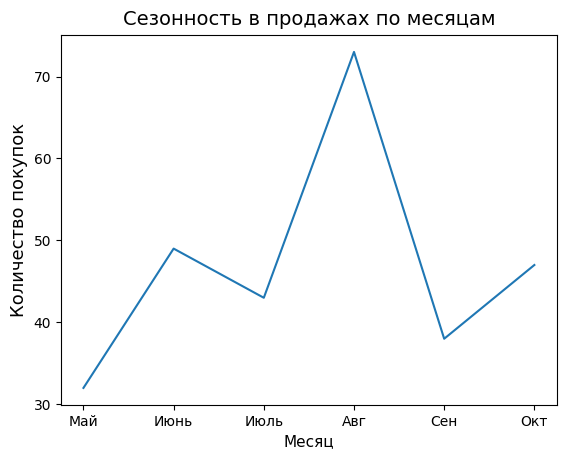

In [27]:
#Сезонность в продажах по месяцам

name_of_month = ['Май', 'Июнь', 'Июль', 'Авг', 'Сен', 'Окт']
value_counts = df.copy()
value_counts['month'] = value_counts['month'].apply(lambda x: name_of_month[x-5])
value_counts = value_counts.groupby(['month'])['payer'].sum().reset_index()
mapping = {day: i for i, day in enumerate(name_of_month)}
key = value_counts['month'].map(mapping)
value_counts = value_counts.iloc[key.argsort()]
value_counts.plot(x='month', legend=False)
plt.xlabel('Месяц', fontsize=11)
plt.ylabel('Количество покупок', fontsize=13)
plt.title('Сезонность в продажах по месяцам', fontsize=14, y=1.005)
plt.show()

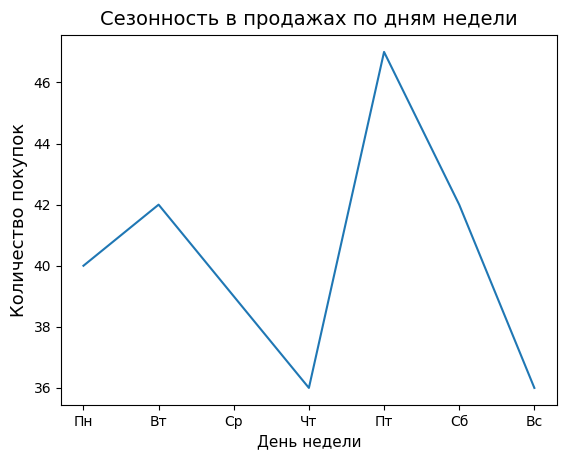

In [28]:
#Сезонность в продажах по дням недели

name_of_day = ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс']
value_counts = df.copy()
value_counts['day'] = value_counts['day'].apply(lambda x: name_of_day[x-1])
value_counts = value_counts.groupby(['day'])['payer'].sum().reset_index()
mapping = {day: i for i, day in enumerate(name_of_day)}
key = value_counts['day'].map(mapping)
value_counts = value_counts.iloc[key.argsort()]
value_counts.plot(x='day', legend=False)
plt.xlabel('День недели', fontsize=11)
plt.ylabel('Количество покупок', fontsize=13)
plt.title('Сезонность в продажах по дням недели', fontsize=14, y=1.005)
plt.show()

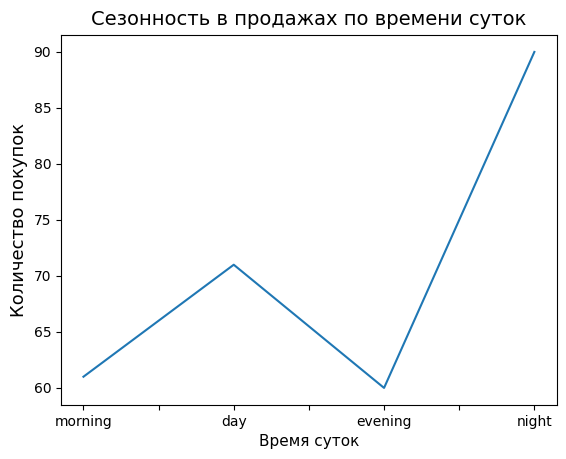

In [29]:
#Сезонность в продажах по времени суток

time_of_day = ['morning', 'day', 'evening', 'night']
value_counts = df.copy()
value_counts = value_counts.groupby(['time_of_day'])['payer'].sum().reset_index()
mapping = {day: i for i, day in enumerate(time_of_day)}
key = value_counts['time_of_day'].map(mapping)
value_counts = value_counts.iloc[key.argsort()]
value_counts.plot(x='time_of_day', legend=False)
plt.xlabel('Время суток', fontsize=11)
plt.ylabel('Количество покупок', fontsize=13)
plt.title('Сезонность в продажах по времени суток', fontsize=14, y=1.005)
plt.show()

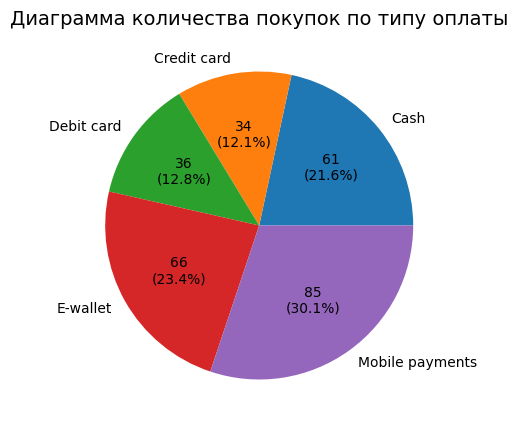

In [30]:
#Диаграмма количества покупок по типу оплаты

def my_fmt(x):
    return '{:.0f}\n({:.1f}%)'.format(df['payer'].sum() * x / 100, x)

value_counts = df[df['payment_type'].notna()].groupby(['payment_type'])['payer'].sum()
ax = value_counts.plot.pie(autopct=my_fmt, labels = value_counts.index,
                          figsize=(15, 5), fontsize=10)
ax.set_ylabel("")
plt.title(label="Диаграмма количества покупок по типу оплаты", fontsize=14)
plt.show()

In [31]:
#есть ли взаимосвязь у продолжительности сессии и девайса (удобно ли смотреть с телефона или нет)
#проверить гипотезу о том, отличаются ли средний чек у людей, имевщих когда-либо промокод, и у людей, никогда его не имевщих
#проверить гипотезу о том, что количество пользователей с промокодами отличается по рекламным каналам
#проверить гипотезу о том, отличаются ли среднее время сессии у людей, имевщих когда-либо промокод, и у людей, никогда его не имевщих

,user_id,region,device,channel,session_start,session_end,sessiondurationsec,session_date,month,day,hour_of_day,order_dt,revenue,payment_type,promo_code,revenue_with_promo_code,payer,time_of_day
0,529697267522,United States,iPhone,социальные сети,2019-05-01 00:06:40,2019-05-01 00:07:06,26.0,2019-05-01,5,3,0,2019-05-01 00:06:40,9999.0,Mobile payments,0.0,9999.0,1,night
1,601292388085,United States,PC,organic,2019-05-01 06:56:16,2019-05-01 07:09:18,782.0,2019-05-01,5,3,7,NaN,NaN,NaN,NaN,NaN,0,morning
2,852898876338,United States,Mac,социальные сети,2019-05-01 04:30:45,2019-05-01 04:34:56,251.0,2019-05-01,5,3,4,NaN,NaN,NaN,NaN,NaN,0,night
3,998513020664,United States,iPhone,социальные сети,2019-05-01 18:53:42,2019-05-01 18:57:35,233.0,2019-05-01,5,3,18,NaN,NaN,NaN,NaN,NaN,0,evening
4,240702200943,United States,Mac,социальные сети,2019-05-02 14:04:32,2019-05-02 14:09:51,319.0,2019-05-02,5,4,14,NaN,NaN,NaN,NaN,NaN,0,day
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
998,246163171672,United States,iPhone,социальные сети,2019-10-29 18:12:24,2019-10-29 18:13:39,75.0,2019-10-29,10,2,18,NaN,NaN,NaN,NaN,NaN,0,evening
999,660140862425,Germany,Android,реклама у блогеров,2019-10-30 19:14:02,2019-10-30 19:46:19,1937.0,2019-10-30,10,3,19,NaN,NaN,NaN,NaN,NaN,0,evening
1000,898253063062,France,iPhone,organic,2019-10-30 03:18:22,2019-10-30 04:43:35,5113.0,2019-10-30,10,3,4,NaN,NaN,NaN,NaN,NaN,0,night
1001,780224321316,United States,iPhone,социальные сети,2019-10-31 22:56:17,2019-10-31 23:42:27,2770.0,2019-10-31,10,4,23,NaN,NaN,NaN,NaN,NaN,0,night
